In [1]:
from anything_vae import (
    ResnetBlock2D,
    SelfAttention,
    Downsample2D,
    Upsample2D,
    DownEncoderBlock2D,
    UpDecoderBlock2D,
    UNetMidBlock2D,
    Encoder,
    Decoder,
    # AutoencoderKL,
    # VGGPerceptualLoss
)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, models as torchvision_models
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
# import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import kornia

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))


In [3]:
class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

In [4]:
import torch
import torch.nn as nn
import torchvision
import kornia  # For color space conversions
from pytorch_lightning import LightningModule
from torchvision.models import vgg16

class Colorizer(LightningModule):
    def __init__(self):
        super(Colorizer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)  # Output 8 channels from quant_conv
        self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)  # Expect 4 channels here
        
        vgg_model = vgg16(weights='DEFAULT')  # Adjust based on your torchvision version
        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.mse_loss_fn = nn.MSELoss()
        
        self.hparams.learning_rate = 0.00001

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)  # h: [batch_size, 8, H, W]
        mean, logvar = torch.chunk(h, 2, dim=1)  # Each: [batch_size, 4, H, W]
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps  # z: [batch_size, 4, H, W]
        return z

    def decode(self, z):
        z = self.post_quant_conv(z)  # z: [batch_size, 4, H, W]
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        x_recon = self.decode(self.encode(x))
        return x_recon

    def configure_optimizers(self):
        return torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=self.hparams.learning_rate
        )

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)

        # Ensure outputs and targets are in [0, 1] range
        outputs = torch.clamp(outputs, 0.0, 1.0)
        targets = torch.clamp(targets, 0.0, 1.0)

        # Convert outputs and targets from RGB to LAB
        outputs_lab = kornia.color.rgb_to_lab(outputs)
        targets_lab = kornia.color.rgb_to_lab(targets)

        # Normalize LAB channels
        outputs_lab[:, 0, :, :] /= 100.0     # L channel from [0, 100] to [0, 1]
        outputs_lab[:, 1:, :, :] /= 128.0    # A and B channels from [-128, 127] to [-1, ~1]

        targets_lab[:, 0, :, :] /= 100.0
        targets_lab[:, 1:, :, :] /= 128.0

        # Compute MSE loss in LAB space
        mse_loss = self.mse_loss_fn(outputs_lab, targets_lab)

        # Compute perceptual loss in RGB space
        perceptual_loss = self.loss_fn(outputs, targets)

        total_loss = perceptual_loss + mse_loss
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('mse_loss', mse_loss)

        # Log images every N batches
        if batch_idx % 1000 == 0:
            num_images = 4
            input_images = inputs[:num_images].detach().cpu()
            target_images = targets[:num_images].detach().cpu()
            output_images = outputs[:num_images].detach().cpu()

            # Concatenate images along width (dim=3)
            combined_images = torch.cat((input_images, target_images, output_images), dim=3)
            grid = torchvision.utils.make_grid(combined_images, nrow=1)

            # Log the combined image grid to TensorBoard
            self.logger.experiment.add_image('Input_Target_Output', grid, self.global_step)

        return total_loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)

        # Ensure outputs and targets are in [0, 1] range
        outputs = torch.clamp(outputs, 0.0, 1.0)
        targets = torch.clamp(targets, 0.0, 1.0)

        # Convert outputs and targets from RGB to LAB
        outputs_lab = kornia.color.rgb_to_lab(outputs)
        targets_lab = kornia.color.rgb_to_lab(targets)

        # Normalize LAB channels
        outputs_lab[:, 0, :, :] /= 100.0     # L channel from [0, 100] to [0, 1]
        outputs_lab[:, 1:, :, :] /= 128.0    # A and B channels from [-128, 127] to [-1, ~1]

        targets_lab[:, 0, :, :] /= 100.0
        targets_lab[:, 1:, :, :] /= 128.0

        # Compute MSE loss in LAB space
        mse_loss = self.mse_loss_fn(outputs_lab, targets_lab)

        # Compute perceptual loss in RGB space
        perceptual_loss = self.loss_fn(outputs, targets)

        total_loss = perceptual_loss + mse_loss
        self.log('val_loss', total_loss)
        self.log('val_perceptual_loss', perceptual_loss)
        self.log('val_mse_loss', mse_loss)

        # Log images once per validation epoch
        if batch_idx == 0:
            num_images = 4
            input_images = inputs[:num_images].detach().cpu()
            target_images = targets[:num_images].detach().cpu()
            output_images = outputs[:num_images].detach().cpu()

            # Concatenate images along width
            combined_images = torch.cat((input_images, target_images, output_images), dim=3)
            grid = torchvision.utils.make_grid(combined_images, nrow=1)

            # Log the combined image grid to TensorBoard
            self.logger.experiment.add_image('Val_Input_Target_Output', grid, self.current_epoch)

        return total_loss

In [5]:
chkpt_file = '~/workspace/checkpoints/version_13.ckpt'
model = Colorizer.load_from_checkpoint(chkpt_file)

In [6]:
# pretrained_model = torch.load('anything-vae.pth', map_location='cpu')
# model = Colorizer()
# pretrained_state_dict = pretrained_model.state_dict()
# missing_keys, unexpected_keys = model.load_state_dict(pretrained_state_dict, strict=False)
# filtered_missing_keys = [key for key in missing_keys if not key.startswith('loss_fn')]
# assert len(filtered_missing_keys) == 0
# assert len(unexpected_keys) == 0

In [7]:
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
logger = loggers.TensorBoardLogger("tb_logs")
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=5, logger=logger, log_every_n_steps=2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, dataloader)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | encoder         | Encoder           | 34.2 M
1 | decoder         | Decoder           | 49.5 M
2 | quant_conv      | Conv2d            | 72    
3 | post_quant_conv | Conv2d            | 20    
4 | loss_fn         | VGGPerceptualLoss | 138 M 
5 | mse_loss_fn     | MSELoss           | 0     
------------------------------------------------------
220 M     Trainable params
1.7 M     Non-trainable params
222 M     Total params
888.046   Total estimated model params size (MB)
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many worker

Epoch 0:  10%|█         | 13071/129629 [1:59:17<17:43:41,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0:  19%|█▉        | 25163/129629 [3:49:32<15:52:56,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0:  37%|███▋      | 48522/129629 [7:22:27<12:19:36,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0:  56%|█████▌    | 72577/129629 [11:02:04<8:40:26,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0:  65%|██████▍   | 84074/129629 [12:47:04<6:55:38,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0:  82%|████████▏ | 106741/129629 [16:14:02<3:28:51,  1.83it/s, v_num=11]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1:   0%|          | 375/129629 [03:25<19:42:01,  1.82it/s, v_num=11]   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1:  23%|██▎       | 30271/129629 [4:36:33<15:07:46,  1.82it/s, v_num=11]

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [10]:
# trainer = Trainer(model, training_dataset, device)
# trainer.train()

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [12]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
  

In [13]:
idx = 10
x, y = test_dataset[idx]
output = model(x.unsqueeze(0))

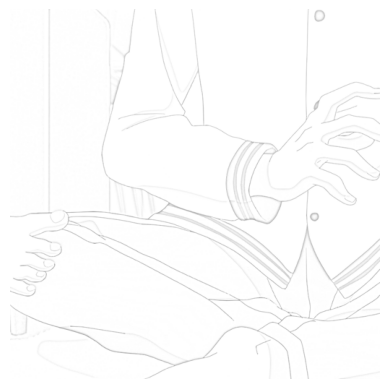

In [14]:
viewTensor(x)

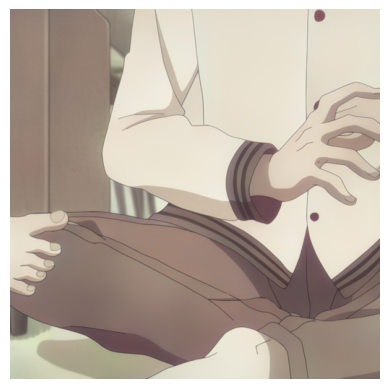

In [15]:
viewTensor(output[0])

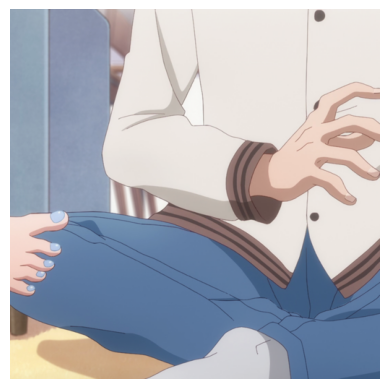

In [16]:
viewTensor(y)